## Task 2: GPS Point Visualization

In [12]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np

in the first vision, the map is too large, so in the next vision, we calculate the first 15 trips to restrict the bounds.

In [13]:
def calculate_boundaries(current_x_max, current_y_max, current_x_min, current_y_min, is_first, longitude, latitude):
    """
    Calculate the boundaries of the coordinates.
    """
    if is_first:
        current_x_min = current_x_max = longitude
        current_y_min = current_y_max = latitude
        is_first = False
    else:
        current_x_max = max(current_x_max, longitude)
        current_x_min = min(current_x_min, longitude)
        current_y_max = max(current_y_max, latitude)
        current_y_min = min(current_y_min, latitude)
    
    return current_x_max, current_y_max, current_x_min, current_y_min, is_first

# Extract the first 15 trajectories and calculate their boundaries
trajectories = []
trajectory_count = 0
x_max = y_max = x_min = y_min = 0
is_first = True

df_15 = pd.read_csv('data/train-1500.csv', nrows=15)

for polyline in df_15['POLYLINE']:
    polyline = polyline[2: -2]
    trajectory = []
    
    if len(polyline) <= 2:
        print(f'Skip empty row {trajectory_count}: Length={len(polyline)}, Element={polyline}')
    else:
        for coordinate in polyline.split('],['):
            longitude, latitude = map(float, coordinate.strip().split(','))
            trajectory.append((longitude, latitude))
            x_max, y_max, x_min, y_min, is_first = calculate_boundaries(x_max, y_max, x_min, y_min, is_first, longitude, latitude)
    
    trajectories.append(trajectory)
    trajectory_count += 1

print(f'xMin: {x_min}, yMin: {y_min}, xMax: {x_max}, yMax: {y_max}')


xMin: -8.689086, yMin: 41.134158, xMax: -8.562348, yMax: 41.180517


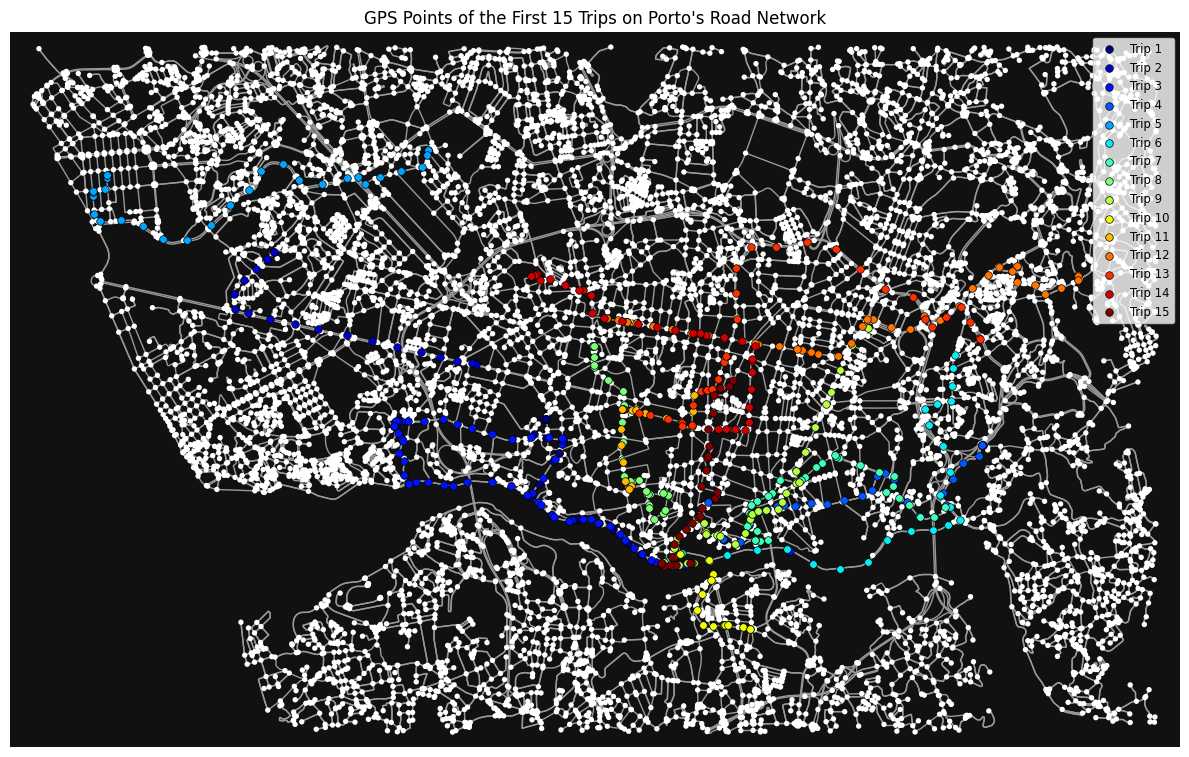

In [14]:
# Create the road network within the calculated boundaries
buffer_distance = 0.01
boundaries = (x_min - buffer_distance, x_max + buffer_distance, y_min - buffer_distance, y_max + buffer_distance)
lower_left_x, upper_right_x, lower_left_y, upper_right_y = boundaries

boundary_polygon = Polygon([(lower_left_x, lower_left_y), (upper_right_x, lower_left_y), (upper_right_x, upper_right_y), (lower_left_x, upper_right_y)])
G = ox.graph_from_polygon(boundary_polygon, network_type='drive')

# Plot the road network
fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(12,12))

# Visualize the first 15 trajectories on the road network
color_map = plt.cm.jet(np.linspace(0, 1, 15))
for i, trajectory in enumerate(trajectories[:15]):
    x_coords, y_coords = zip(*trajectory)
    ax.scatter(x_coords, y_coords, s=30, label=f'Trip {i+1}', color=color_map[i], edgecolor='k', linewidth=0.5)

ax.set_title("GPS Points of the First 15 Trips on Porto's Road Network")
plt.legend(loc="upper right", fontsize='small')
plt.tight_layout()
plt.show()
